In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import torch as tn
import random
import warnings
import multiprocessing as mp
from functools import partial
from scipy.integrate import quad, IntegrationWarning
import time
from concurrent.futures import ThreadPoolExecutor


# Import files
from constants import *
from pdfpy import *
from functions import  d_sigma, d_sigma_sm, sigma_sm, sme, sigma_full, summation_terms, integrate_sigma_hat_prime_sm, integrate_sigma_hat_prime_sme
from rotation import *

LHAPDF 6.5.4 loading /home/ahmed/miniconda3/envs/env1/share/LHAPDF/NNPDF31_nnlo_as_0118/NNPDF31_nnlo_as_0118_0000.dat
NNPDF31_nnlo_as_0118 PDF set, member #0, version 1; LHAPDF ID = 303600


In [2]:
# Quarks
quarks = [
    (2, 2/3*e, 'u', 1/2),
     (1, -1/3*e, 'd', -1/2),
     (3, -1/3*e, 's', -1/2),
     (4, 2/3*e, 'c', 1/2),
      (5, -1/3*e, 'b', -1/2),
    #  (6, 2/3*e, 't', 1/2),
]

# List of quark properties and couplings
quark_couplings = []

for flavor, e_f, name, I3 in quarks:
    g_fR = -e_f * sin2th_w
    g_fL = I3 - e_f * sin2th_w
    
    # Rounding to 4 decimal places
    e_f = round(e_f, 4)
    g_fR = round(g_fR, 4)
    g_fL = round(g_fL, 4)
    
    quark_couplings.append((flavor, e_f, g_fR, g_fL))

print(quark_couplings)

[(2, 0.2019, -0.0467, 0.4533), (1, -0.1009, 0.0233, -0.4767), (3, -0.1009, 0.0233, -0.4767), (4, 0.2019, -0.0467, 0.4533), (5, -0.1009, 0.0233, -0.4767)]


In [3]:
 # quark_couplings = [(2, 0.2019, -0.0467, 0.4533), (1, -0.1009, 0, -0.4767)]

In [4]:
#Don't foregt the metric convenction (+, -, -, -)
g = tn.tensor([
    [1,0,0,0],
    [0,-1,0,0],
    [0,0,-1,0],
    [0,0,0,-1]
], dtype=tn.float32)
CL1 = tn.tensor([
    [0, 0, 0, 0],
    [0, 1e-5, 0, 0],
    [0, 0, -1e-5, 0],
    [0,0, 0, 0]
], dtype=tn.float32)
CL2 = tn.tensor([
    [0, 0, 0, 0],
    [0, 0, -1e-5, 0],
    [0, -1e-5, 0, 0],
    [0,0, 0, 0]
], dtype=tn.float32)
CL3 = tn.tensor([
    [0, 0, 0, 0],
    [0, 0, 0, -1e-5],
    [0, 0, 0, 0],
    [0,-1e-5, 0, 0]
], dtype=tn.float32)
CL4 = tn.tensor([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, -1e-5],
    [0,0,-1e-5, 0]
], dtype=tn.float32)

CLzz = tn.tensor([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0,0,0, -1e-5]
], dtype=tn.float32)

CR = tn.tensor([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
], dtype=tn.float32)

# C0 = tn.tensor([
#     [0, 0, 0, 0],
#     [0, 0, 0, 0],
#     [0, 0, 0, 0],
#     [0, 0, 0, 0]
# ], dtype=tn.float32)

In [5]:
# Define the constant tensors once
p1 =  0.5*tn.tensor([1, 0, 0, 1], dtype=tn.float32)
p2 =  0.5*tn.tensor([1, 0, 0, -1], dtype=tn.float32)

# Precompute total number of steps

specific_time = datetime(2018, 1, 1, 0, 0)

start_time = int(specific_time.timestamp())

# start_time = int(time.time())
end_time = start_time + int(timedelta(days=1).total_seconds())
step_seconds = int(timedelta(hours=1).total_seconds())
num_steps = (end_time - start_time) // step_seconds

# Lists to store the times and contr matrix elements
times = []
contrelep1 = []
contrelep2 = []

R_y_lat = R_y(latitude)
R_x_azi = R_x(azimuth)

# Main loop
current_time = start_time
for _ in range(num_steps):
    # Convert current_time to a timestamp
    current_datetime = datetime.fromtimestamp(current_time)
    time_utc = current_datetime.timestamp()

    # Calculate omega_t
    omega_t_sid = omega_utc * time_utc + 3.2830 
    # Construct the complete rotation matrix from SCF to CMS
    R_Z_omega = R_Z(omega_t_sid)
    
    R_mat = tn.matmul(R_y_lat, tn.matmul(R_x_azi, tn.matmul(R_z, R_Z_omega)))
    R_matrix1 = tn.einsum('am,na->mn', g, R_mat)
    R_matrix2 = tn.einsum('ma,an->mn', g, R_mat)

    # Compute contrL and contrR using matrix multiplication
    contrp1 = tn.einsum('ij,j->i', R_matrix1, p1)
    contrp2 =  tn.einsum('ij,i->j',R_matrix2, p2)

    # Record the times and contr matrix elements
    times.append(current_time)
    contrelep1.append(contrp1)
    contrelep2.append(contrp2)


    # Move to the next time step
    current_time += step_seconds

In [6]:
# # Generate a list random of Q values 
# Q_values = []
# for _ in range(len(contrelep1)):
#     while True:
#         Q = np.random.normal(loc=75, scale=2)
#         if 70 <= Q <= 80:
#             Q_values.append(Q)
#             break

In [7]:
# warnings.simplefilter("ignore", IntegrationWarning)

# def compute_result(args):
#     pm, pn, Q, quark_couplings, CL1, CL2, CL3, CL4, CR = args
    
#     # Calculate Q^2
#     Q2 = Q**2
    
#     # Perform all calculations with the same Q for this iteration
#     result_sm = d_sigma_sm(Q2, quark_couplings)
#     result_sme1 = d_sigma(Q2, CL1, CR, pm, pn, quark_couplings)
#     result_sme2 = d_sigma(Q2, CL2, CR, pm, pn, quark_couplings)
#     result_sme3 = d_sigma(Q2, CL3, CR, pm, pn, quark_couplings)
#     result_sme4 = d_sigma(Q2, CL4, CR, pm, pn, quark_couplings)
    
#     # Return the result as a dictionary
#     return {
#         'Q': Q,
#         'result_sm': result_sm,
#         'result_sme1': result_sme1,
#         'result_sme2': result_sme2,
#         'result_sme3': result_sme3,
#         'result_sme4': result_sme4
#     }

# # Prepare the arguments for parallel processing
# args_list = [(pm, pn, 70, quark_couplings, CL1, CL2, CL3, CL4, CR) 
#              for (pm, pn) in zip(contrelep1, contrelep2)]

# # Create a multiprocessing Pool
# with mp.Pool(mp.cpu_count()) as pool:
#     # Pass sigma_sm_value to compute_result via lambda function
#     results = pool.map(lambda args: compute_result(args, sigma_sm_value), args_list)

# # Function to convert timestamps to hours
# def convto_hours(timestamps):
#     start_time = timestamps[0]  # The start time to normalize
#     return [(t - start_time) / 3600 for t in timestamps]  # Convert seconds to hours

# # Perform conversion
# hours_start = convto_hours(times)


In [8]:
%%time

warnings.simplefilter("ignore", IntegrationWarning)

def compute_result(args, sigma_sm_value):
    pm, pn, quark_couplings, CL1, CL2, CL3, CL4, CR = args
    
    # Calculate Q^2
    Q_min = 70
    Q_max = 80  
    
    # Compute the SME contributions
    result_sme1 = sme(Q_min, Q_max, CL1, CR, pm, pn, quark_couplings, sigma_sm_value)
    result_sme2 = sme(Q_min, Q_max, CL2, CR, pm, pn, quark_couplings, sigma_sm_value)
    result_sme3 = sme(Q_min, Q_max, CL3, CR, pm, pn, quark_couplings, sigma_sm_value)
    result_sme4 = sme(Q_min, Q_max, CL4, CR, pm, pn, quark_couplings, sigma_sm_value)
    
    # Add the SM result to each of the SME results after the loop
    final_result_sme1 = result_sme1 + sigma_sm_value
    final_result_sme2 = result_sme2 + sigma_sm_value
    final_result_sme3 = result_sme3 + sigma_sm_value
    final_result_sme4 = result_sme4 + sigma_sm_value
    
    # Return the result as a dictionary
    return {
        'result_sme1': final_result_sme1,
        'result_sme2': final_result_sme2,
        'result_sme3': final_result_sme3,
        'result_sme4': final_result_sme4
    }

# Calculate sigma_sm once outside the loop since it doesn't depend on p1, p2, or CL.
Q_min = 70
Q_max = 80
sigma_sm_value = sigma_sm(Q_min, Q_max, quark_couplings)

# Prepare the arguments for parallel processing
args_list = [(pm, pn, quark_couplings, CL1, CL2, CL3, CL4, CR) 
             for (pm, pn) in zip(contrelep1, contrelep2)]

# Create a partial function to include sigma_sm_value
partial_compute_result = partial(compute_result, sigma_sm_value=sigma_sm_value)

# Create a multiprocessing Pool
with mp.Pool(mp.cpu_count()) as pool:
    # Pass the partial function to pool.map
    results = pool.map(partial_compute_result, args_list)

# Function to convert timestamps to hours
def convto_hours(timestamps):
    start_time = timestamps[0]  # The start time to normalize
    return [(t - start_time) / 3600 for t in timestamps]  # Convert seconds to hours

# Perform conversion
hours_start = convto_hours(times)

KeyboardInterrupt: 

In [9]:
# Calculate dratios in a compact way
dratios = [np.array([result[f'result_sme{i+1}'] / sigma_sm_value for result in results]) for i in range(4)]
hours_array = np.array(hours_start)

# Define labels and colors
labels = [
    r'$C_{L,XX} = - C_{L,YY} = 10^{-5}$',
    r'$C_{L,XY} = C_{L,YX} = 10^{-5}$',
    r'$C_{L,XZ} = C_{L,ZX} = 10^{-5}$',
    r'$C_{L,YZ} = C_{L,ZY} = 10^{-5}$'
]
colors = ['r', 'b', 'g', 'gold']

plt.figure(figsize=(15, 10))

# Plot each dratio using a loop
for i in range(4):
    plt.step(hours_array, dratios[i], where='post', color=colors[i], label=labels[i], linewidth=1.5)

# Customizing the legend
plt.legend(loc='upper left', bbox_to_anchor=(0.9, 1), fontsize=10, frameon=True)

# Adding labels and title 
plt.xlabel('Time (hours)', fontsize=12)
plt.ylabel(r'$\sigma_{SME}/\sigma_{SM}$', fontsize=12)
plt.title(r'$SME/SM \; at \; Q \in [70,80] \;GeV$', fontsize=16, loc='left')
plt.text(12, 1.009, '2018', fontsize=20, horizontalalignment='center')

plt.minorticks_on()
plt.tick_params(axis='x', which='minor', bottom=False)  
plt.tick_params(which='both', width=1)
plt.tick_params(which='major', length=7)
plt.tick_params(which='minor', length=4, color='gray')
plt.tick_params(axis='y', direction='in', which='both') 

plt.xticks(ticks=range(0, 24, 1), labels=[str(hour) for hour in range(0, 24, 1)])

plt.tight_layout(rect=[0, 0, 0.8, 0.8]) 

# Showing the plot
plt.savefig("liv.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

NameError: name 'results' is not defined

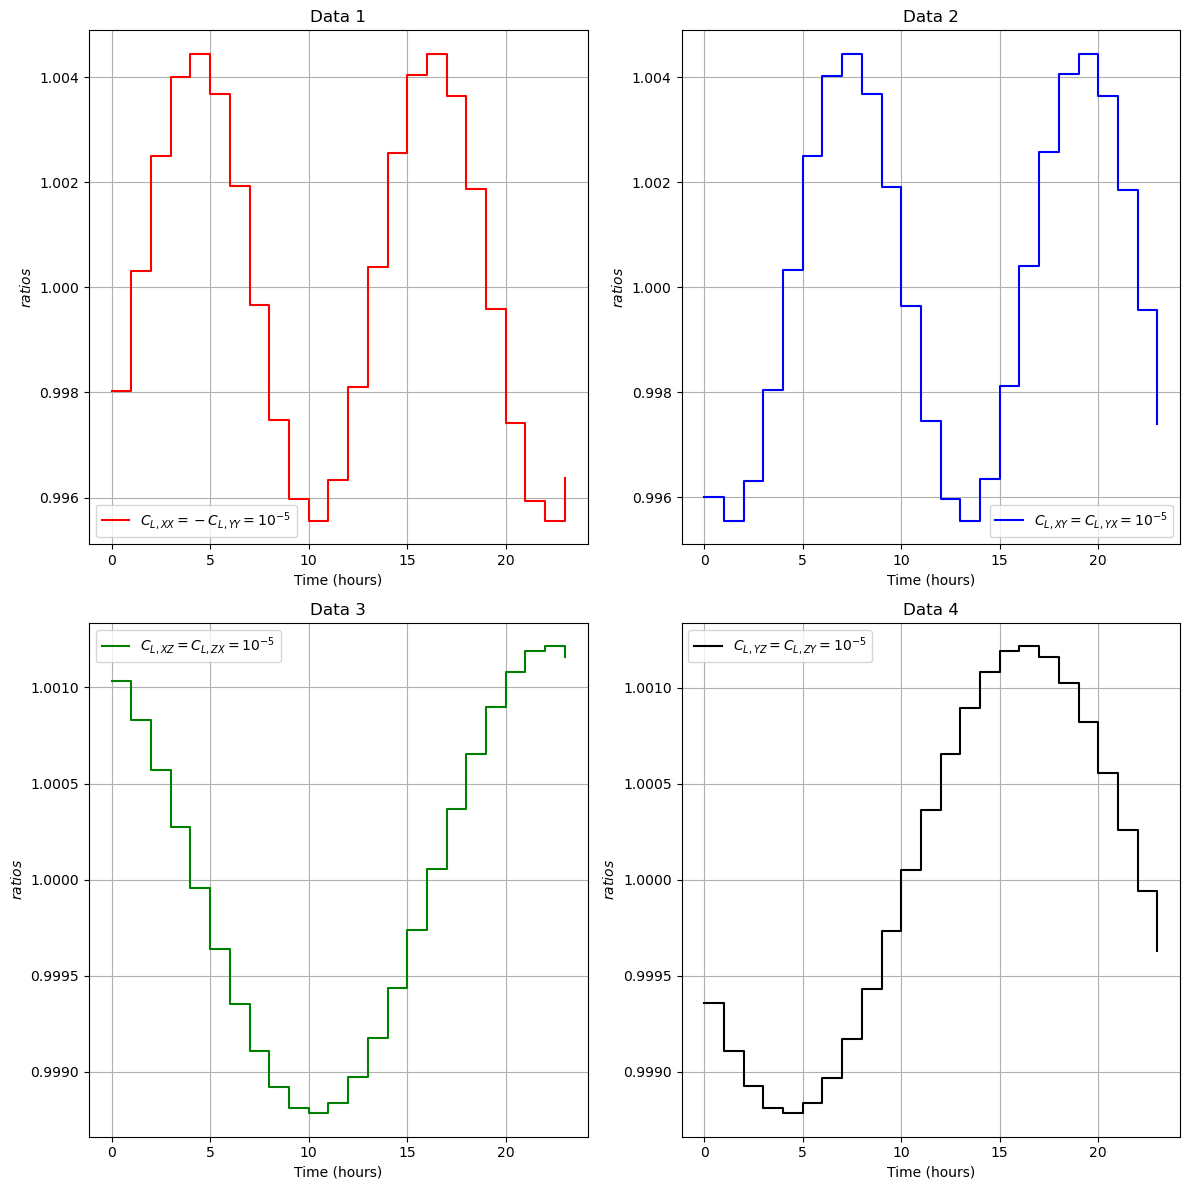

In [10]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot data in each subplot
axs[0, 0].step(hours_array, dratios[0], where='post', color='r', label='$C_{L,XX} = - C_{L,YY} = 10^{-5}$')
axs[0, 0].set_title('Data 1')
axs[0, 0].set_xlabel('Time (hours)')
axs[0, 0].set_ylabel('$ratios$')
axs[0, 0].grid(True)
axs[0, 0].legend()

axs[0, 1].step(hours_array, dratios[1], where='post', color='b', label='$C_{L,XY} = C_{L,YX} = 10^{-5}$')
axs[0, 1].set_title('Data 2')
axs[0, 1].set_xlabel('Time (hours)')
axs[0, 1].set_ylabel('$ratios$')
axs[0, 1].grid(True)
axs[0, 1].legend()

axs[1, 0].step(hours_array, dratios[2], where='post', color='g', label='$C_{L,XZ} = C_{L,ZX} = 10^{-5}$')
axs[1, 0].set_title('Data 3')
axs[1, 0].set_xlabel('Time (hours)')
axs[1, 0].set_ylabel('$ratios$')
axs[1, 0].grid(True)
axs[1, 0].legend()

axs[1, 1].step(hours_array, dratios[3], where='post', color='black', label='$C_{L,YZ} = C_{L,ZY} = 10^{-5}$')
axs[1, 1].set_title('Data 4')
axs[1, 1].set_xlabel('Time (hours)')
axs[1, 1].set_ylabel('$ratios$')
axs[1, 1].grid(True)
axs[1, 1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [6]:
%%time
def compute_sme_for_bin(Q_range):
    # Unpack the tuple
    Q_start, Q_end = Q_range
    # Function to compute SME for a given range
    return sme(Q_start, Q_end, CLzz, CLzz, p1, p2, quark_couplings)

if __name__ == '__main__':
    Q_val = np.linspace(17.5, 90, 100)
    a = 17.5  # Start of the Q range
    b = 90  # End of the Q range
    nbins = 17  # Number of bins

    Q_bins = np.linspace(a, b, nbins + 1)

    # Prepare the list of arguments for each bin
    bin_ranges = [(Q_bins[i], Q_bins[i + 1]) for i in range(len(Q_bins) - 1)]

    # Use multiprocessing to compute SME values
    with mp.Pool() as pool:
        sme_values = pool.map(compute_sme_for_bin, bin_ranges)

/home/ahmed/Desktop/test (Copy)/cross section variation Q80/functions.py:73: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result2, _ = quad(integrand2, tau, 1)
/home/ahmed/Desktop/test (Copy)/cross section variation Q80/functions.py:73: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result2, _ = quad(integrand2, tau, 1)
/home/ahmed/Desktop/test (Copy)/cross section variation Q80/functions.py:73: IntegrationWarning: The maximum number of subdivisions (50) has be

CPU times: user 34.6 ms, sys: 105 ms, total: 140 ms
Wall time: 4min 11s


In [8]:
print([sme_values[-1]])
print(sme_values)
print(sme_values + [sme_values[-1]])

[214.24977674690788]
[549.9612443342668, 195.02570333804556, 83.2291999934792, 41.031401223179365, 22.888501940638786, 14.312079148082372, 9.983112201327724, 7.731057503149249, 6.605904045458957, 6.184383042107927, 6.308073159288714, 7.002408847037312, 8.519908506453385, 11.613115420002044, 18.69293853432376, 40.90379578968041, 214.24977674690788]
[549.9612443342668, 195.02570333804556, 83.2291999934792, 41.031401223179365, 22.888501940638786, 14.312079148082372, 9.983112201327724, 7.731057503149249, 6.605904045458957, 6.184383042107927, 6.308073159288714, 7.002408847037312, 8.519908506453385, 11.613115420002044, 18.69293853432376, 40.90379578968041, 214.24977674690788, 214.24977674690788]


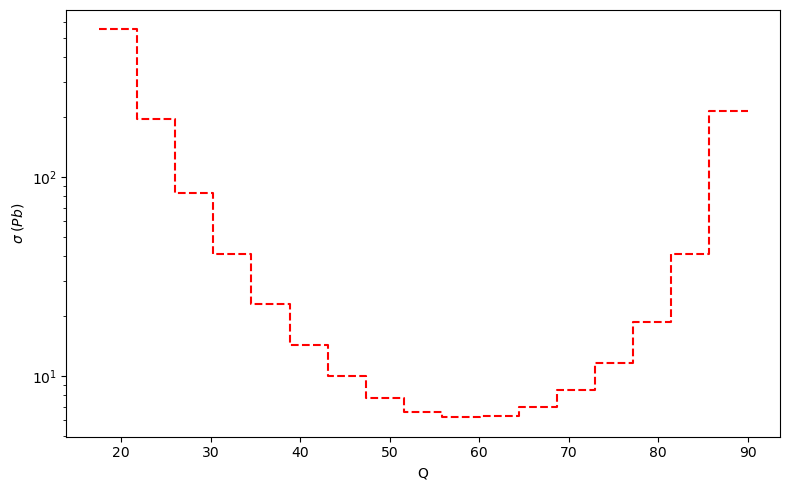

In [9]:
plt.figure(figsize=(8, 5))

# Create the step plot
plt.step(Q_bins,  sme_values + [sme_values[-1]], where='post', color='r', linestyle='--')

plt.xlabel('Q')
plt.yscale('log')
plt.ylabel('$\\sigma \\;(Pb)$')

# plt.grid(True, which="both", ls="--")  
plt.tight_layout()

# Save and show the plot
plt.savefig('intrsec.png')
plt.show()



In [ ]:
# # Integration and plotting
# Q_val = np.linspace(17.5, 90, 100)
# a = 17.5 # Start of the Q range
# b = 90  # End of the Q range
# nbins = 17  # Number of bins
# # Example momenta for protons
# p1 = 1 / np.sqrt(2) * tn.tensor([1,0, 0,1], dtype=tn.float32)

# p2 = 1 / np.sqrt(2) * tn.tensor([1,0, 0,-1], dtype=tn.float32)


# Q_bins = np.linspace(a, b, nbins + 1)

# def integrand(Q, CL, CR, p1, p2, quark_couplings):
#     return d_sigma(Q, CL, CR, p1, p2, quark_couplings)

# # Integration function for a bin using quad
# def integrate_bin(args):
#     Q_start, Q_end, CL, CR, p1, p2, quark_couplings = args
#     integral, _ = quad(integrand, Q_start, Q_end, args=(CL, CR, p1, p2, quark_couplings))
#     return integral

# if __name__ == '__main__':
#     a = 17.5  # Start of the Q range
#     b = 90    # End of the Q range
#     nbins = 17  # Number of bins

#     Q_bins = np.linspace(a, b, nbins + 1)

#     # Prepare the arguments for multiprocessing
#     bin_ranges = [(Q_bins[i], Q_bins[i + 1], CLzz, CLzz, p1, p2, quark_couplings) for i in range(len(Q_bins) - 1)]

#     # Use multiprocessing to integrate over each bin in parallel
#     with mp.Pool() as pool:
#         integrated_values = pool.map(integrate_bin, bin_ranges)

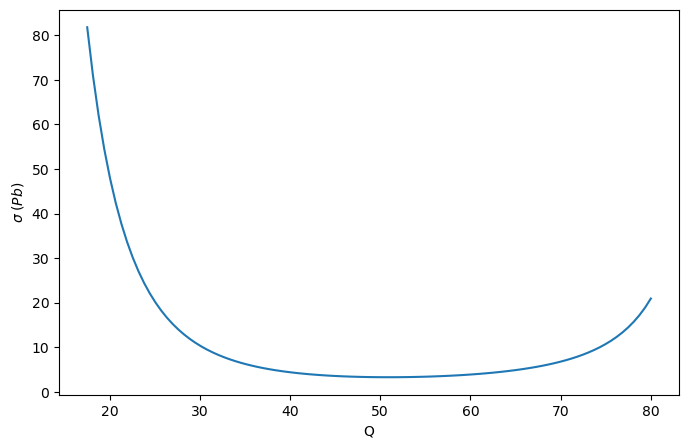

In [18]:
QQ= np.linspace(17.5,80,100)

kp =[summation_terms(Q, 0.2013, 0.4551) for Q in QQ] 

plt.figure(figsize=(8, 5))

# Create the step plot
plt.plot(QQ, kp)

plt.xlabel('Q')
# plt.yscale('log')
plt.ylabel('$\\sigma \\;(Pb)$')
# plt.title(f'Integrated d_sigma over Q bins for $C^{{33}}_{{uL}}=${c_33L} and $C^{{33}}_{{uR}}=${c_33R}')
plt.show()

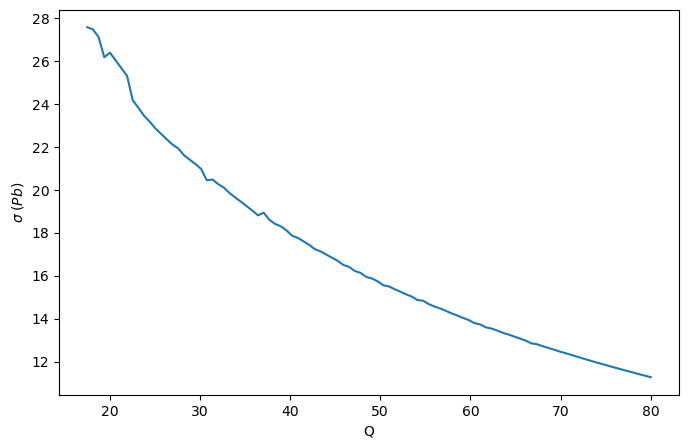

In [19]:
A = 1 / np.sqrt(2)
p1 = A * tn.tensor([1, 0, 0, 1], dtype=tn.float32)
p2 = A * tn.tensor([1, 0, 0, -1], dtype=tn.float32)
QQ2= np.linspace(17.5,80,100)

jk = [(integrate_sigma_hat_prime_sme(Q**2/s,CLzz, p1, p2,2, Q)+ integrate_sigma_hat_prime_sm(Q**2/s, 2, Q) )for Q in QQ2]

plt.figure(figsize=(8, 5))

# Create the step plot
plt.plot(QQ, jk)

plt.xlabel('Q')
# plt.yscale('log')
plt.ylabel('$\\sigma \\;(Pb)$')
# plt.title(f'Integrated d_sigma over Q bins for $C^{{33}}_{{uL}}=${c_33L} and $C^{{33}}_{{uR}}=${c_33R}')
plt.show()

tensor([0.7071067691, 0.0000000000, 0.0000000000, 0.7071067691])


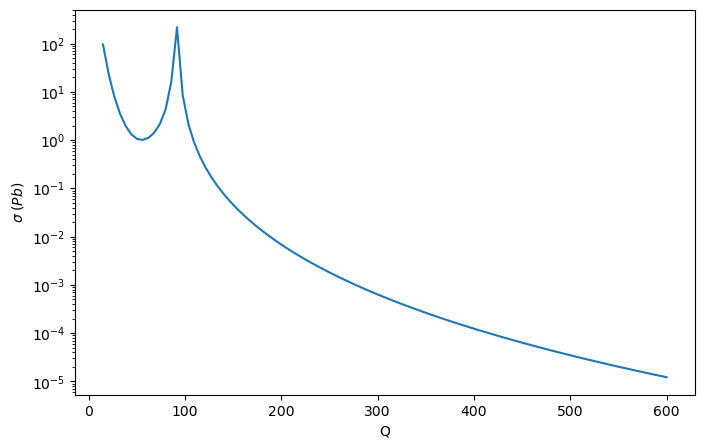

In [8]:
qq= np.linspace(15,100,100)
ii = [ 100* d_sigma_sm(Q**2, quark_couplings) for Q in qq]
plt.figure(figsize=(8, 5))

# Create the step plot
plt.plot(qq, ii)

plt.xlabel('Q')
plt.yscale('log')
plt.ylabel('$\\sigma \\;(Pb)$')
# plt.title(f'Integrated d_sigma over Q bins for $C^{{33}}_{{uL}}=${c_33L} and $C^{{33}}_{{uR}}=${c_33R}')
plt.show()

In [9]:
ii = sigma_sm(50, 80, quark_couplings)
pp = sigma_sm(80, 100, quark_couplings)
kk = sigma_sm(100, 13e3, quark_couplings)
print(ii+pp+kk)

/home/ahmed/Desktop/test (Copy)/cross section variation Q80/functions.py:132: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int, _ = quad(inet, Qmin**2, Qmax**2)
/home/ahmed/Desktop/test (Copy)/cross section variation Q80/functions.py:64: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result1, _ = quad(integrand1, tau, 1)


1951.1748470534642


/home/ahmed/Desktop/test (Copy)/cross section variation Q80/functions.py:132: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int, _ = quad(inet, Qmin**2, Qmax**2)
